In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.sampler import RandomSampler
from warmup_scheduler import GradualWarmupScheduler
import albumentations
from work.utils.dataset import RGB2Fusion, PandasDataset
from work.utils.models import EfficientNet
from work.utils.train import train_model
from work.utils.metrics import model_checkpoint
import random
import matplotlib.pyplot as plt

In [2]:
backbone_model = 'efficientnet-b0'
pretrained_model = {
    backbone_model: '../efficientnet-b0-08094119.pth'
}
data_dir = '../../dataset'
images_dir = os.path.join(data_dir, 'tiles')

df_train = pd.read_csv(f"../data/train_5fold.csv")

In [3]:
seed = 42
shuffle = True
batch_size = 2

num_workers = 4
output_classes = 5
init_lr = 3e-4
warmup_factor = 10
warmup_epochs = 1
n_epochs = 15
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
loss_function = nn.BCEWithLogitsLoss()

torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))


Using device: cuda
True
1
NVIDIA GeForce RTX 3060


In [4]:
transforms = albumentations.Compose([
    RGB2Fusion(mode="mean", space_colors=["rgb", "xyz", "lab"]),
    albumentations.Transpose(p=0.5),
    albumentations.VerticalFlip(p=0.5),
    albumentations.HorizontalFlip(p=0.5),
])

valid_transforms =albumentations.Compose([
    RGB2Fusion(mode="mean", space_colors=["rgb", "xyz", "lab"]),
])

In [5]:
df_train.columns = df_train.columns.str.strip()

train_indexes = np.where((df_train['fold'] != 3))[0]
valid_indexes = np.where((df_train['fold'] == 3))[0]

train = df_train.loc[train_indexes]
valid = df_train.loc[valid_indexes]

train_dataset = PandasDataset(images_dir, train, transforms=transforms)
valid_dataset = PandasDataset(images_dir, valid, transforms=valid_transforms)

In [6]:
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=2, num_workers=num_workers, sampler = RandomSampler(train_dataset)
)
valid_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=2, num_workers=num_workers, sampler = RandomSampler(valid_dataset)
)

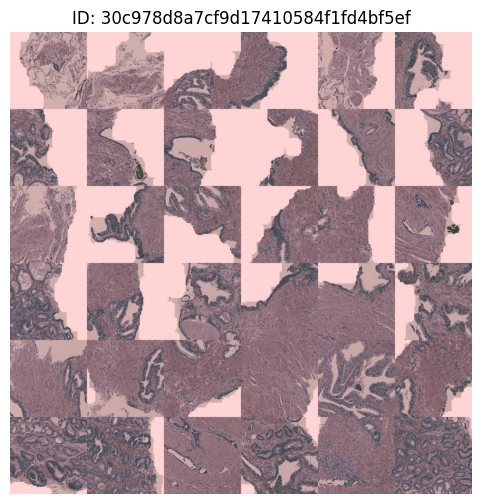

In [7]:
data_iter = iter(train_loader)
images, labels, ids = next(data_iter)

img = images[0]

plt.figure(figsize=(6, 6))
plt.imshow(img.permute(1, 2, 0).numpy().astype(np.uint8))
plt.axis('off')
plt.title(f'ID: {ids[0]}')
plt.savefig("mean.png", dpi=300)
plt.show()

In [8]:
model = EfficientNet(
    backbone=backbone_model,
    output_dimensions=output_classes,
    pre_trained_model=pretrained_model
)
model = model.to(device)

Loaded pretrained weights for efficientnet-b0


In [9]:
optimizer = optim.Adam(model.parameters(), lr = init_lr / warmup_factor)
scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs - warmup_epochs)
scheduler = GradualWarmupScheduler(optimizer, multiplier = warmup_factor, total_epoch = warmup_epochs, after_scheduler=scheduler_cosine)
save_path = f'models/fusion-mean.pth'

In [10]:
train_model(
    model=model,
    epochs=n_epochs,
    optimizer=optimizer,
    scheduler=scheduler,
    train_dataloader=train_loader,
    valid_dataloader=valid_loader,
    checkpoint=model_checkpoint,
    device=device,
    loss_function=loss_function,
    path_to_save_metrics="logs/with-noise-fusion-mean-3-images.txt",
    path_to_save_model=save_path
)

Epoch 1/15



100%|██████████| 903/903 [15:38<00:00,  1.04s/it]


Salvando o melhor modelo... 0.0 -> 0.7466419486333505
Epoch 2/15



100%|██████████| 903/903 [15:36<00:00,  1.04s/it]


Epoch 3/15



100%|██████████| 903/903 [15:43<00:00,  1.04s/it]


Salvando o melhor modelo... 0.7466419486333505 -> 0.8165260636514937
Epoch 4/15



100%|██████████| 903/903 [15:33<00:00,  1.03s/it]


Salvando o melhor modelo... 0.8165260636514937 -> 0.8225790285955299
Epoch 5/15



100%|██████████| 903/903 [15:29<00:00,  1.03s/it]


Salvando o melhor modelo... 0.8225790285955299 -> 0.8373489214904831
Epoch 6/15



100%|██████████| 903/903 [15:31<00:00,  1.03s/it]


Salvando o melhor modelo... 0.8373489214904831 -> 0.8385442663328225
Epoch 7/15



100%|██████████| 903/903 [15:33<00:00,  1.03s/it]


Salvando o melhor modelo... 0.8385442663328225 -> 0.8447067412149097
Epoch 8/15



100%|██████████| 903/903 [15:33<00:00,  1.03s/it]


Salvando o melhor modelo... 0.8447067412149097 -> 0.8481219764204977
Epoch 9/15



100%|██████████| 903/903 [15:38<00:00,  1.04s/it]


Epoch 10/15



100%|██████████| 903/903 [15:40<00:00,  1.04s/it]


Epoch 11/15



100%|██████████| 903/903 [15:46<00:00,  1.05s/it]


Epoch 12/15



100%|██████████| 903/903 [15:42<00:00,  1.04s/it]


Salvando o melhor modelo... 0.8481219764204977 -> 0.8509796932146383
Epoch 13/15



100%|██████████| 903/903 [15:53<00:00,  1.06s/it]


Epoch 14/15



100%|██████████| 903/903 [15:46<00:00,  1.05s/it]


Epoch 15/15



100%|██████████| 903/903 [15:49<00:00,  1.05s/it]
